# Housing prices dataset

## Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

In [2]:
df = pd.read_csv("train (1).csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Validation

In [3]:
# check for duplicate rows

df[df.duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [4]:
# does the data have missing values ?
# filter columns with more than 70 %  missing values
missing_values_col=set(df.columns[df.isnull().sum()/df.shape[0]>0.40].values)
missing_values_col

#filter columns with fewer missing values
all_missing_values=set(df.columns[df.isnull().sum()/df.shape[0]>0].values)
list(all_missing_values-missing_values_col)

## conclusion
# we need to remove columns with missing value percentage> 70 and impute columns with missing values <70

['Electrical',
 'BsmtFinType2',
 'GarageQual',
 'BsmtQual',
 'MasVnrArea',
 'BsmtCond',
 'MasVnrType',
 'LotFrontage',
 'BsmtFinType1',
 'GarageType',
 'GarageFinish',
 'GarageYrBlt',
 'GarageCond',
 'BsmtExposure']

In [5]:
missing_values_col=list(missing_values_col)
df=df.drop(missing_values_col,axis=1)

In [6]:
#check missing values in MaxVntType
df['MasVnrType'].isnull().sum()

#since the rows are small we can remove them
df=df[~(df['MasVnrType'].isnull())]

In [7]:
#check columns with missing values less than 5 %
# remove rows with missing values for these columns
missing_values_col=df.columns[(df.isnull().sum()/df.shape[0]>0) & (df.isnull().sum()/df.shape[0] <0.05)].values
for col in missing_values_col:
    df=df[~df[col].isnull()]

In [8]:
df.isnull().sum()/df.shape[0]

# few columns have less than 6 % of missing values they can be removed as well
missing_values_col=df.columns[(df.isnull().sum()/df.shape[0]>0) & (df.isnull().sum()/df.shape[0] <0.06)].values
for col in missing_values_col:
    df=df[~df[col].isnull()]

In [9]:
#Checking missing values after removing the other rows
df.columns[df.isnull().sum()/df.shape[0]>0].values

array(['LotFrontage'], dtype=object)

In [10]:
#df[['FireplaceQu','LotFrontage']].isnull().sum()/df.shape[0]
# 44 % of FireplaceQu has missing values . In the data description NA refers to no fireplace. So it can be replaced with "none"

#df['FireplaceQu']=df['FireplaceQu'].fillna(value='None')

In [11]:
df['LotFrontage'].describe()
# fill missing values with median
df['LotFrontage']=df['LotFrontage'].fillna(value='70.00')

### Check Data type of columns

In [12]:
# binary variables to 0 and 1

df['CentralAir']=df['CentralAir'].map({'Y':0,'N':1})

In [13]:
# convert LotFrontage to float
df['LotFrontage']=df['LotFrontage'].apply(lambda x: float(x))

In [14]:
df['Street']=df['Street'].map({'Grvl':0,'Pave':1})

### Outlier analysis

In [15]:
def removeOutliers(X,featureName):
    Q1 = np.percentile(X[featureName],q=25)
    Q3= np.percentile(X[featureName],q=75)
    QR = Q3-Q1
    lower_limit = Q1- (1.5* QR)
    upper_limit = Q3 +(1.5*QR)
    print("removing outliers for feature name "+ str(X[~((X[featureName]> lower_limit) & (X[featureName]<upper_limit))].shape[0]))
    return X[(X[featureName]<upper_limit) & (X[featureName]>lower_limit)]


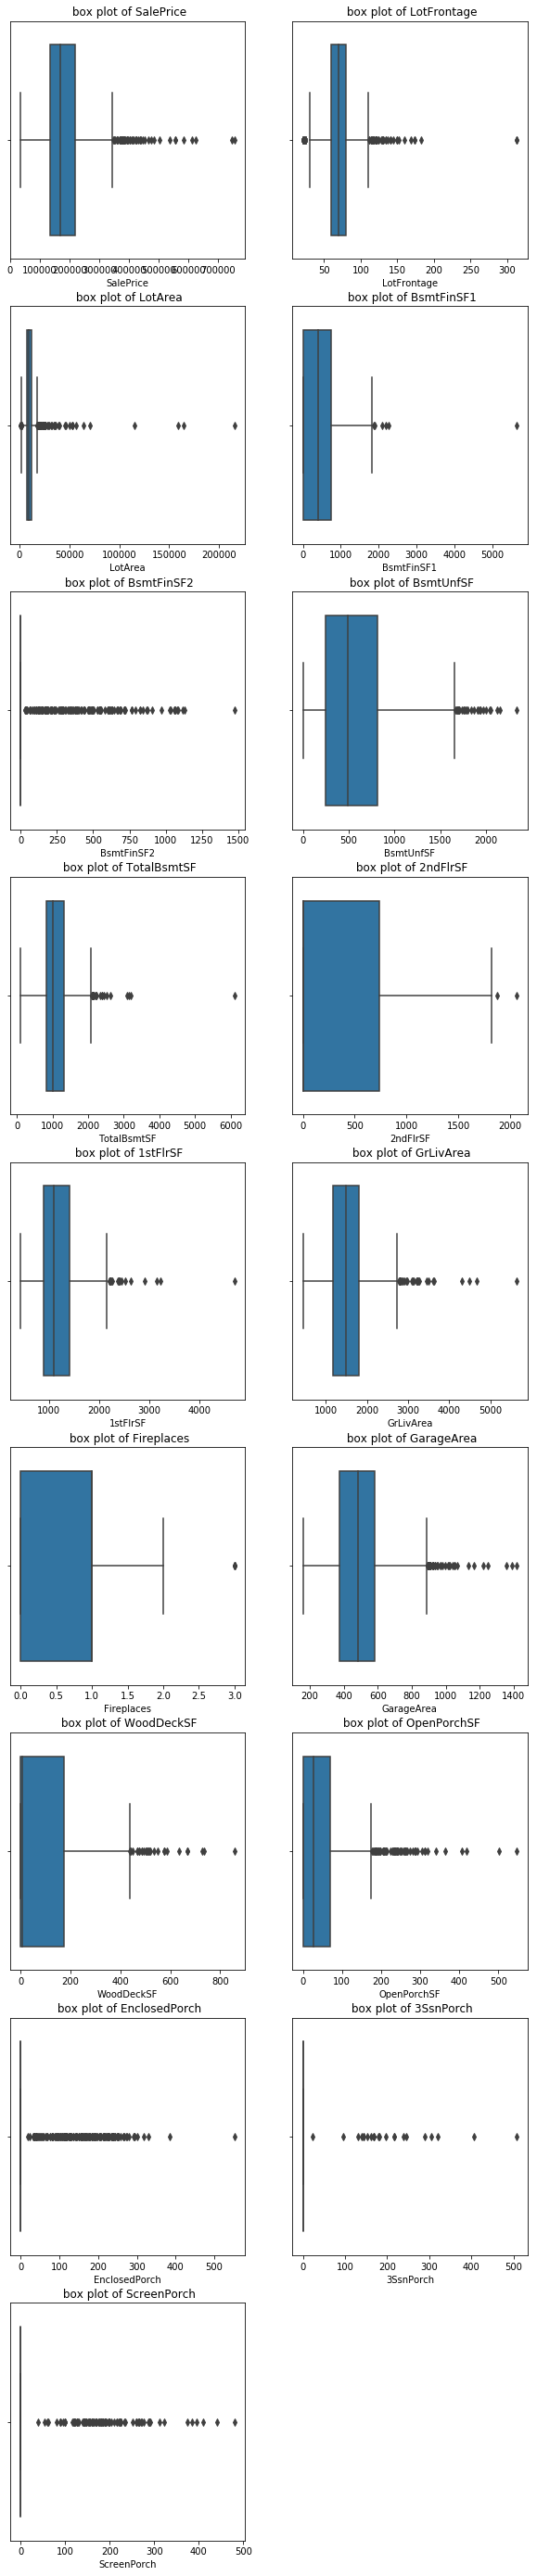

In [16]:
# visualise outliers in data
plt.figure(figsize=(10,50))
area_vars =['SalePrice','LotFrontage','LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','2ndFlrSF','1stFlrSF','GrLivArea','Fireplaces','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']
for i in range(1,len(area_vars)):
    plt.subplot(9,2,i)
    sns.boxplot(df[area_vars[i-1]])
    plt.title(" box plot of "+area_vars[i-1])

plt.show()

#conclusion
# SalePrice,LotFrontage,BsmtUnfSF,TotalBsmtSF,GrLivArea,GarageArea,OpenPorchSF,WoodDeckSF

In [17]:
# removing outliers for sale price
#SalePrice,LotFrontage,BsmtUnfSF,TotalBsmtSF,GrLivArea,GarageArea,OpenPorchSF,WoodDeckSF
df=removeOutliers(df,'SalePrice')

removing outliers for feature name 56


In [18]:
# removing outliers for LotFrontage
df=removeOutliers(df,'LotFrontage')

removing outliers for feature name 102


In [19]:
# removing outliers for BsmtUnfSF
df=removeOutliers(df,'BsmtUnfSF')


removing outliers for feature name 18


In [20]:
# removing outliers for GrLivArea
df=removeOutliers(df,'GrLivArea')

removing outliers for feature name 20


In [21]:
# removing outliers for TotalBsmtSF
df=removeOutliers(df,'TotalBsmtSF')

removing outliers for feature name 11


In [22]:
# removing outliers for GarageCars
df=removeOutliers(df,'GarageArea')

removing outliers for feature name 14


In [23]:
# removing outliers for GarageCars
df=removeOutliers(df,'OpenPorchSF')

removing outliers for feature name 56


In [24]:
# removing outliers for GarageCars
df=removeOutliers(df,'WoodDeckSF')

removing outliers for feature name 21


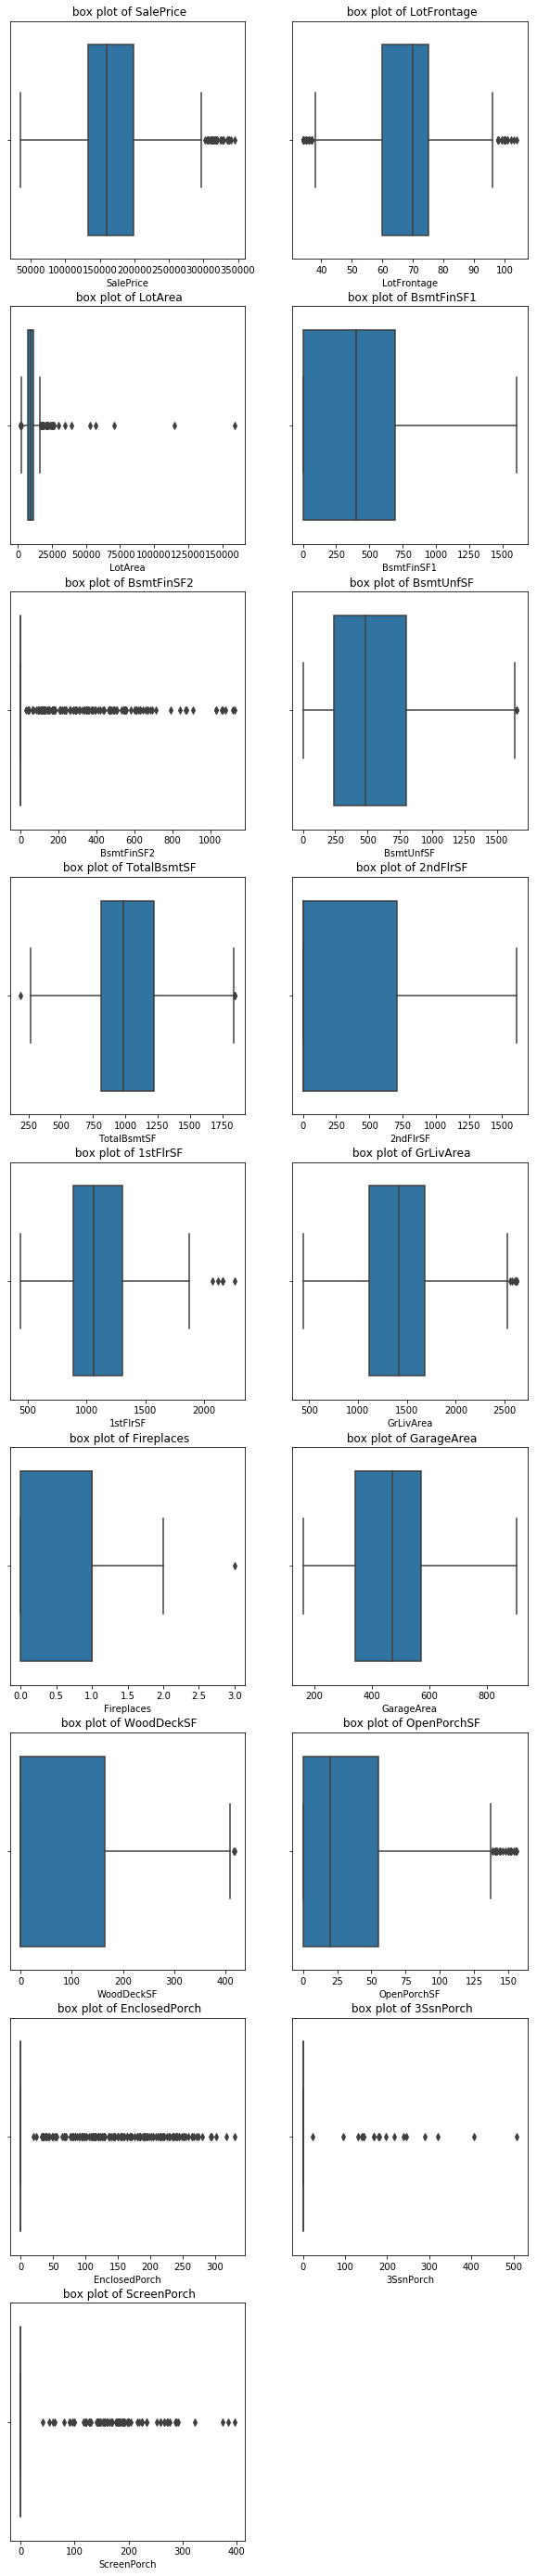

In [25]:
# visualise outliers in data
plt.figure(figsize=(10,50))
area_vars =['SalePrice','LotFrontage','LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','2ndFlrSF','1stFlrSF','GrLivArea','Fireplaces','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']
for i in range(1,len(area_vars)):
    plt.subplot(9,2,i)
    sns.boxplot(df[area_vars[i-1]])
    plt.title(" box plot of "+area_vars[i-1])

plt.show()

#variables EnclosedPorch,3SsnPorch,ScreenPorch,LotArea,BsmtFinSF2 can be removed

## Exploratory Data Analysis

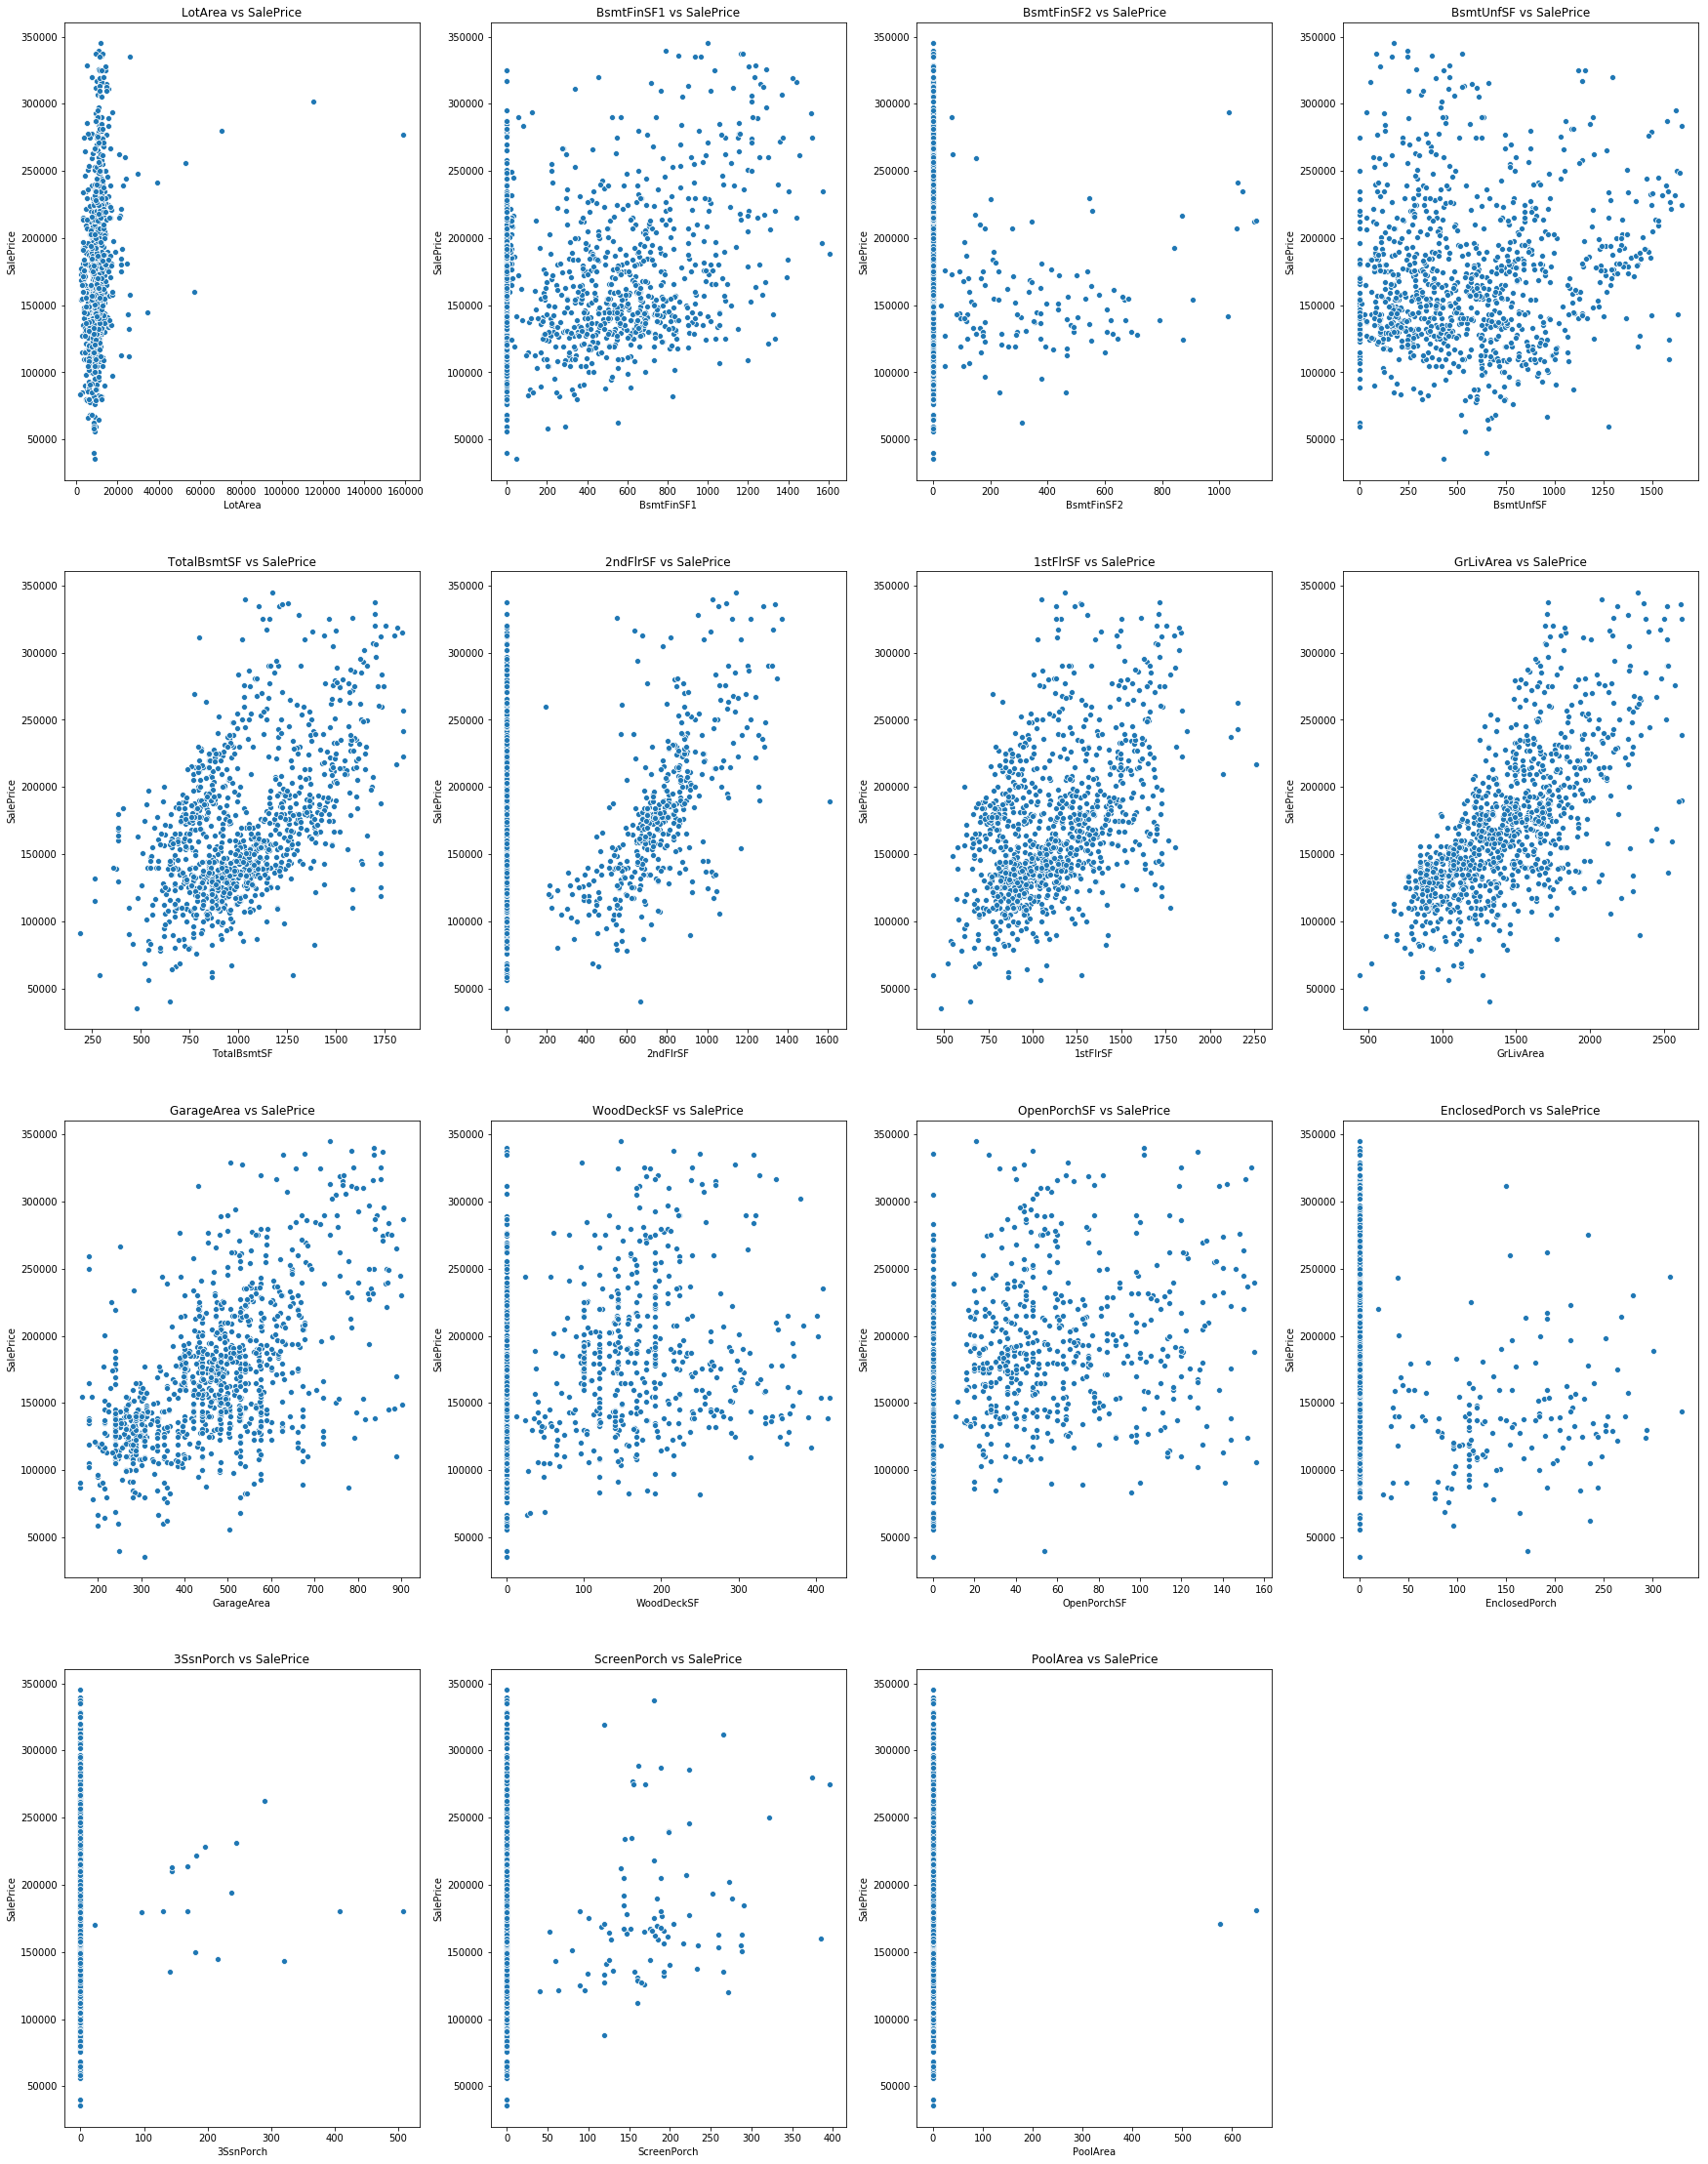

In [26]:
# how are area variables related to sale price ?
plt.figure(figsize=(30,50))
area_vars =['LotFrontage','LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','2ndFlrSF','1stFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']
for i in range(1,len(area_vars)):
    plt.subplot(5,4,i)
    sns.scatterplot(x=df[area_vars[i]],y=df['SalePrice'])
    plt.title(area_vars[i] +" vs SalePrice")

plt.show()

# conclusion
# TotalBsmtSF , GrvLivArea, GarageArea ,1stFlrSF show a slightly linear relationship with saleprice.
# PoolArea,3SsnPorch,ScreenPorch have majority of the data as 0. These variables don't show any significant relationship with sale price

In [27]:
df['PoolArea'].value_counts()

#since majority of pool area column has 0, it can be removed.
df=df.drop('PoolArea',axis=1)

In [28]:
df['3SsnPorch'].value_counts(normalize=True)

# since majority contains 0, the column can be removed from further analysis
df= df.drop('3SsnPorch',axis=1)

In [29]:
df['ScreenPorch'].value_counts(normalize=True)

#since majority of pool area column has 0, it can be removed.
df=df.drop('ScreenPorch',axis=1)

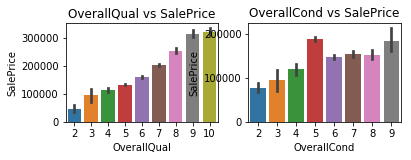

In [30]:
#categorical variables

# How does overall quality influence the sale price ?
plt.subplot(2,2,1)
sns.barplot(x=df['OverallQual'],y=df['SalePrice'])
plt.title("OverallQual vs SalePrice")


# From the graph, it is clear that higher quality rating has a higher price.

plt.subplot(2,2,2)
sns.barplot(x=df['OverallCond'],y=df['SalePrice'])
plt.title("OverallCond vs SalePrice")

plt.show()

#overall condition rating 5 seems to have the highest sale price

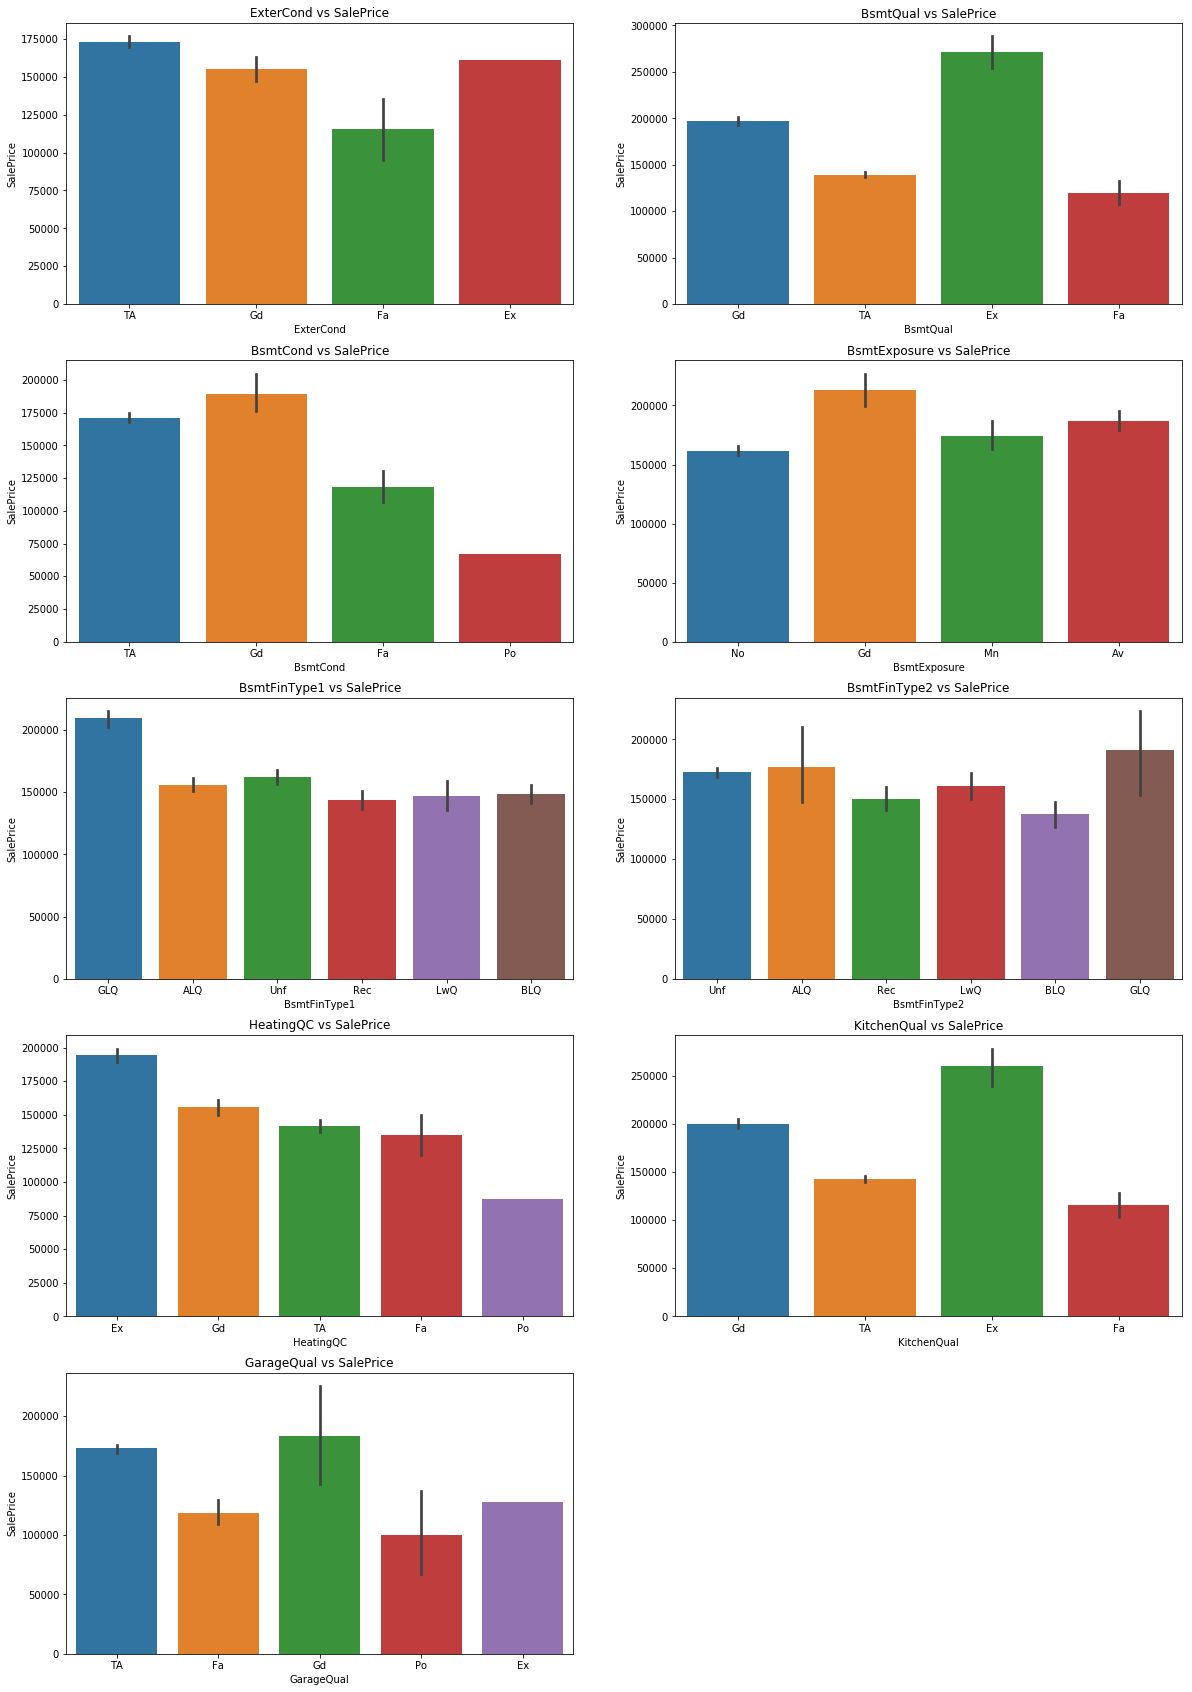

In [31]:
# How does overall quality influence the sale price ?
plt.figure(figsize=(20,30))
quality_and_condition_vars = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','GarageQual']
for i in range(1,len(quality_and_condition_vars)):
    plt.subplot(5,2,i)
    sns.barplot(x=df[quality_and_condition_vars[i]],y=df['SalePrice'])
    plt.title(quality_and_condition_vars[i]+" vs SalePrice")

plt.show()

# From the graph, it is clear that higher quality rating has a higher price.

# heating quality and kitchen quality with rating excellent have the highest price

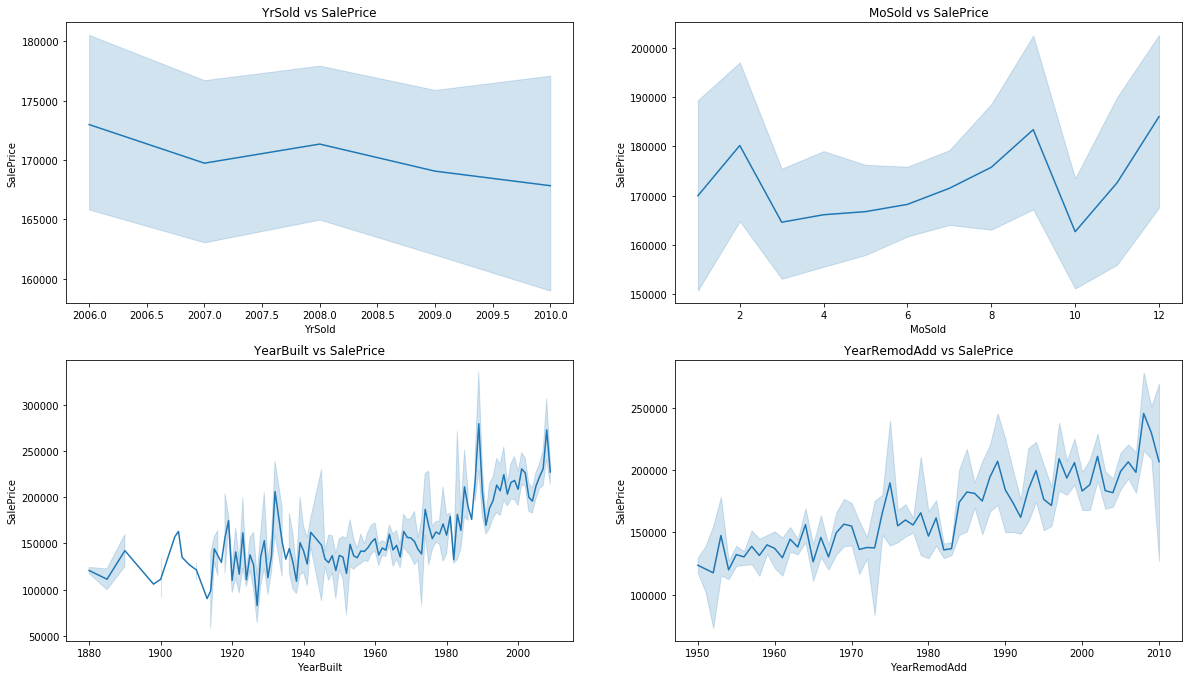

In [32]:
# how does year build , year sold , year remodelled affect the sale price ?

year_vars =['YrSold','MoSold','YearBuilt','YearRemodAdd']
plt.figure(figsize=(20,30))
for i in range(1,len(year_vars)+1):
    plt.subplot(5,2,i)
    sns.lineplot(df[year_vars[i-1]],y=df['SalePrice'])
    plt.title(year_vars[i-1]+" vs SalePrice")

plt.show()

# conclusions
#1. the recent years have higher sale prices associated with them.
#2. The houses which are re modelled recently are sold at higher prices

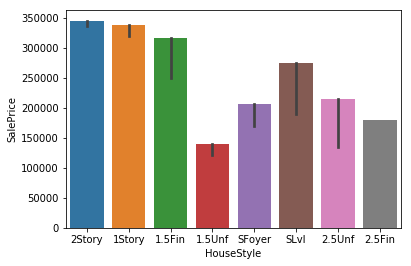

HouseStyle
1.5Fin    316600
1.5Unf    139400
1Story    337500
2.5Fin    179500
2.5Unf    214500
2Story    345000
SFoyer    206300
SLvl      275000
Name: SalePrice, dtype: int64

In [33]:
#HouseStyle vas salePrice
sns.barplot(x=df['HouseStyle'],y=df['SalePrice'],estimator=max)
plt.show()

#House with two stories have the highest price
df.groupby('HouseStyle')['SalePrice'].max()

#1 story and 2 story have the maximum sale price associated with it.

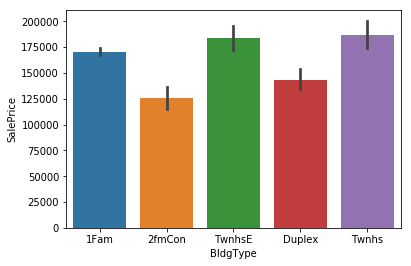

In [34]:
#HouseStyle vas salePrice
sns.barplot(x=df['BldgType'],y=df['SalePrice'])
plt.show()

# TwnhsE has the highest average sale price

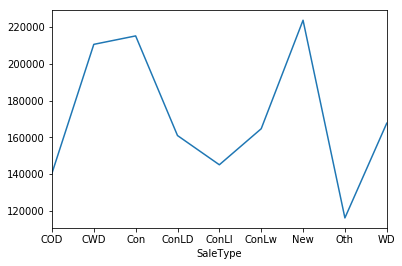

In [35]:
df.groupby('SaleType')['SalePrice'].mean().plot()
plt.show()

#Contract 15% Down payment regular terms has an higher average sale price
#Home just constructed and sold have higher sale price

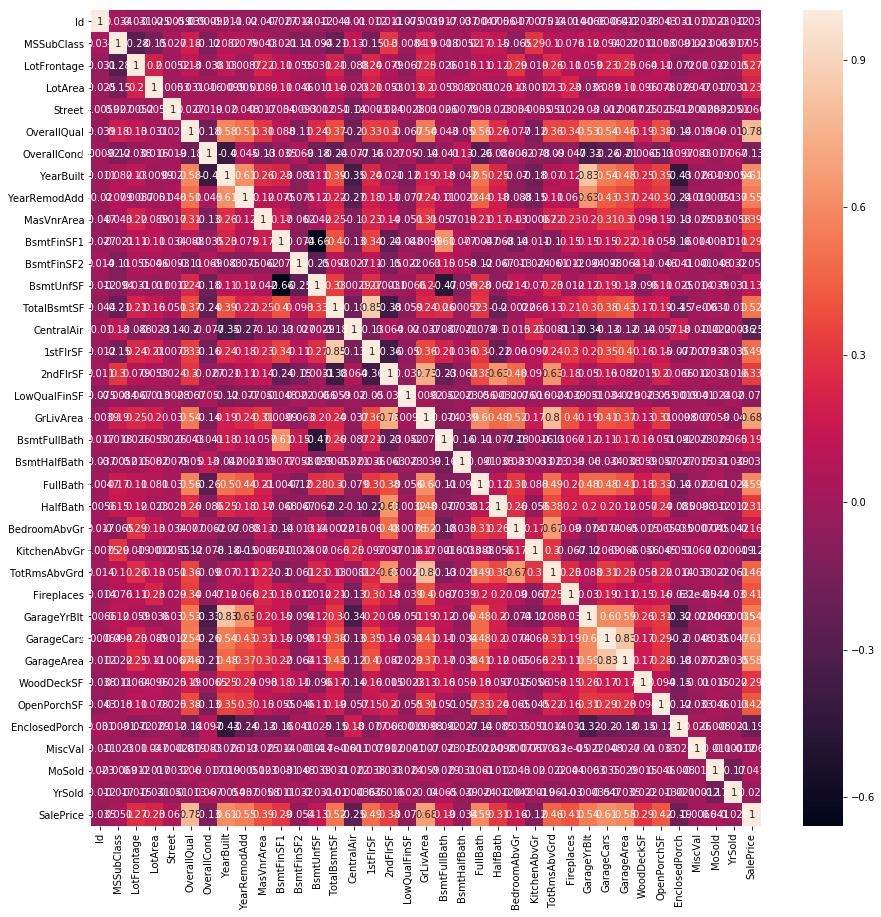

In [36]:
#correlation with other variables
corr_value = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_value,annot=True)
plt.show()

#garage cars and garage area have high correlation
#garage year built and year built have high correlation
#overral quality has a high correlation with sale price

### Data Preparation

In [37]:
# convert ordinal variables into label encoders 
from sklearn.preprocessing import LabelEncoder
ordinal_vars=['HeatingQC','KitchenQual','GarageQual','GarageCond','ExterQual','ExterCond','BsmtQual','BsmtCond',
             'BsmtFinType2','BsmtFinType1','BsmtExposure','MSSubClass','Fireplaces']

encoder = LabelEncoder()
for col in ordinal_vars:
    df[col]=encoder.fit_transform(df[col])

In [38]:
# binning of year and month variable
df['YearBuilt'].describe()

# convert yearbuilt to date
#df['YearBuilt']=df['YearBuilt'].apply(lambda x: int(round(x)))
#pd.qcut(df['YearBuilt'],q=6)
#df['YearBuilt'].describe()
#df['YearBuilt']=pd.to_datetime(df['YearBuilt'].astype(str),format='%Y.%m')
#df['YearBuilt']=pd.DatetimeIndex(df['YearBuilt']).year
#df['YearBuilt'].describe()

#df['YearBuilt']=pd.DatetimeIndex(df['YearBuilt']).year
#pd.cut(df['YearBuilt'],bins=8)

count    1040.000000
mean     1970.664423
std        29.465464
min      1880.000000
25%      1953.000000
50%      1971.500000
75%      1999.250000
max      2009.000000
Name: YearBuilt, dtype: float64

In [39]:
df['YearRemodAdd'].describe()


count    1040.000000
mean     1984.099038
std        20.856557
min      1950.000000
25%      1965.000000
50%      1993.000000
75%      2003.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

In [40]:
df['GarageYrBlt'].describe()
#df['GarageYrBlt']= pd.Categorical(df['GarageYrBlt'])
#df['GarageYrBlt'].value_counts()

count    1040.000000
mean     1976.404808
std        25.179673
min      1900.000000
25%      1959.000000
50%      1977.000000
75%      2000.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [41]:
df['YrSold'].describe()
df['YrSold']=pd.Categorical(df['YrSold'])

In [42]:
df['MoSold'].describe()
df['MoSold']=pd.Categorical(df['MoSold'])


In [43]:
# drop id column
df=df.drop('Id',axis=1)

In [44]:
# categorical variables 
cat_vars=['MSZoning','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','SaleCondition',
          'SaleType','PavedDrive','GarageFinish','GarageType','Functional','Electrical','Heating']

df2 = pd.get_dummies(df[cat_vars],drop_first=True)
df2

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,Functional_Min2,Functional_Mod,Functional_Typ,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Heating_GasW,Heating_Grav,Heating_OthW
0,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
6,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
8,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
10,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [45]:
df3=pd.concat([df,df2],axis=1)

In [46]:
df3=df3.drop(cat_vars,axis=1)

### Split into train and test data

In [47]:
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df3,random_state=100,train_size=0.8,test_size=0.2)

### Rescaling the data

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [49]:
df_train[df_train.columns]=scaler.fit_transform(df_train)

C:\Users\Rakshu\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Rakshu\Anaconda\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [50]:
df_test[df_test.columns]=scaler.transform(df_test)

C:\Users\Rakshu\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Rakshu\Anaconda\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [51]:
X_train= df_train.drop('SalePrice',axis=1)
y_train = df_train['SalePrice']

In [52]:
#rescale test data as well
X_test= df_test.drop('SalePrice',axis=1)
y_test = df_test['SalePrice']

In [53]:
X_train['Heating_OthW'].value_counts()

0.0    831
1.0      1
Name: Heating_OthW, dtype: int64

In [54]:
#scaler = MinMaxScaler()
#X_train[X_train.columns]=scaler.fit_transform(X_train)
#X_test[X_test.columns]= scaler.transform(X_test)

In [55]:
#scaler= MinMaxScaler()
#y_train= scaler.fit_transform(y_train.reshape(-1,1))
#y_test= scaler.transform(y_test.reshape(-1,1))

In [56]:
#scaler.transform(X_test)

## Feature selection and modelling

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def removeCorrelatedFeatures(X,threshold,total_features):
    for i in total_features:
        #X = X[columns]
        df_vif= pd.DataFrame()
        df_vif['VIF']=[variance_inflation_factor(X.values,j) for j in range(X.shape[1])]
        df_vif=df_vif.set_index(X.columns)
        #feature = total_features[i]
        features=df_vif[df_vif['VIF']==max(df_vif.max())].index
        max_vif = df_vif.max()[0]
        #feature_vif = df_vif.loc[i][0]
        if(max_vif >threshold):
            X = X.drop(features[0],axis=1)
            print("removing "+ features[0]+" with vif "+str(max_vif))
    
    return df_vif

In [58]:
# Removing features which are highly correlated with other features using VIF. Here a threshold of 5 is choosen
df2=removeCorrelatedFeatures(X_train,5,X_train.columns)

C:\Users\Rakshu\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Rakshu\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


removing 1stFlrSF with vif inf
removing Exterior1st_BrkComm with vif inf
removing Exterior1st_CBlock with vif inf
removing TotalBsmtSF with vif 133353.13897569958


C:\Users\Rakshu\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1388: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


removing Street with vif 1687.3664690664866
removing Condition2_Norm with vif 929.4613335378581
removing RoofStyle_Gable with vif 447.9992828265402
removing Functional_Typ with vif 302.3319582451172
removing GarageType_Attchd with vif 258.6742638968991
removing MSZoning_RL with vif 198.149772005964
removing YearBuilt with vif 169.66259625282416
removing Exterior1st_VinylSd with vif 140.07987353812692
removing GrLivArea with vif 139.8862684966496
removing ExterCond with vif 81.96206086837329
removing GarageCond with vif 73.33374880154692
removing ExterQual with vif 67.18123748179421
removing GarageYrBlt with vif 63.7042624171782
removing BsmtFinType2 with vif 63.65998537993689
removing OverallQual with vif 54.1710765822323
removing BedroomAbvGr with vif 53.871674837985324
removing MasVnrType_None with vif 52.12400159484268
removing Exterior2nd_MetalSd with vif 49.033284453748415
removing MSSubClass with vif 48.55300351845637
removing LandContour_Lvl with vif 43.95181912449197
removing C

In [59]:
selected_columns = df2.index
X_train=X_train[selected_columns]

In [60]:
len(selected_columns)
# a total of 130 features are present after removing features with high VIF

130

In [61]:
X_train=X_train[selected_columns]
X_test=X_test[selected_columns]

### Modelling

#### Using Ridge

In [62]:
# modelling
from sklearn.model_selection import GridSearchCV

In [63]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,Ridge,Lasso

In [64]:
def train_ridge_rfe(noOfFeatures,X,y):
    #lr = LinearRegression()
    #lm = lr.fit(X_train,y_train)
    ridge = Ridge()
    rfe = RFE(ridge,noOfFeatures)
    rfe = rfe.fit(X_train,y_train)
    columns = X.columns[rfe.support_]
    folds = 5
    #ridge = Ridge()
    params = {'alpha':np.linspace(0.05,50)}
    model_cv = GridSearchCV(estimator=ridge,cv=folds,param_grid=params,scoring='neg_mean_absolute_error',return_train_score=True,verbose=1) 
    model_cv.fit(X[columns],y)
    return columns,model_cv.best_params_
    

In [65]:
from sklearn.metrics import r2_score
def train_ridge(X_train,y_train,X_test,y_test,alpha):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train,y_train)
    y_pred_train = ridge.predict(X_train)
    y_pred_test= ridge.predict(X_test)
    train_r2= r2_score(y_train,y_pred_train)
    test_r2 = r2_score(y_test,y_pred_test)
    return train_r2,test_r2,ridge

In [66]:
no_of_features_list=[10,15,20,25,30,35,40,45,50,55,60]
df_rfe = pd.DataFrame()
rfe_dict= {}
for i in no_of_features_list:
    columns,alpha=train_ridge_rfe(i,X_train,y_train)
    print('Optimal lambda value for '+ str(i) +' features is '+ str(alpha))
    train_r2,test_r2,ridge = train_ridge(X_train[columns],y_train,X_test[columns],y_test,alpha['alpha'])
    rfe_dict['noOfFeatures']= i
    rfe_dict['alpha']= alpha['alpha']
    rfe_dict['train_score']= train_r2
    rfe_dict['test_score']= test_r2
    df_rfe= df_rfe.append(pd.DataFrame(data=pd.DataFrame([rfe_dict])))

C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 10 features is {'alpha': 0.05}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 15 features is {'alpha': 0.05}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 20 features is {'alpha': 0.05}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 25 features is {'alpha': 0.05}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 30 features is {'alpha': 0.05}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=35 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 35 features is {'alpha': 0.05}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=40 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 40 features is {'alpha': 0.05}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=45 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 45 features is {'alpha': 0.05}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=50 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 50 features is {'alpha': 0.05}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=55 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 55 features is {'alpha': 1.069387755102041}


C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=60 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal lambda value for 60 features is {'alpha': 1.069387755102041}


In [67]:
df_rfe

,alpha,noOfFeatures,test_score,train_score
0,0.050000,10,0.469444,0.491100
0,0.050000,15,0.500789,0.525526
0,0.050000,20,0.550933,0.645618
0,0.050000,25,0.564165,0.655946
0,0.050000,30,0.621628,0.690829
0,0.050000,35,0.620691,0.704988
0,0.050000,40,0.642719,0.728721
0,0.050000,45,0.647190,0.743356
0,0.050000,50,0.669850,0.753211
0,1.069388,55,0.686990,0.749993


In [68]:
# let's recompute coefficients for 60 features with alpha=1.06938
columns,alpha=train_ridge_rfe(60,X_train,y_train)
train_r2,test_r2,ridge = train_ridge(X_train[columns],y_train,X_test[columns],y_test,alpha['alpha'])
ridge_df = pd.DataFrame(list(zip(columns,ridge.coef_)),columns=['feature','coefficient'])

C:\Users\Rakshu\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=60 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [69]:
# coefficient for 60 features
ridge_df.sort_values(by='coefficient',ascending=False).head()

,feature,coefficient
0,MasVnrArea,0.222901
21,Neighborhood_NoRidge,0.194854
22,Neighborhood_NridgHt,0.143744
23,Neighborhood_StoneBr,0.134064
24,Neighborhood_Timber,0.127849


In [70]:
# what if we increase alpha?
train_r2,test_r2,ridge = train_ridge(X_train[columns],y_train,X_test[columns],y_test,alpha=2.1638)
ridge_df = pd.DataFrame(list(zip(columns,ridge.coef_)),columns=['feature','coefficient'])
print("training r2 score"+str(train_r2))
print("testing r2 score "+str(test_r2))

training r2 score0.7501645590677039
testing r2 score 0.6942870665991379


#### Using Lasso

In [71]:
def train_lasso(X,y):
    folds = 5
    lasso = Lasso()
    params = {'alpha':[0.001,0.025,0.05,0.1,0.15,0.175,0.2,0.25,0.275,0.3,0.35,0.375,0.4,0.45,0.475,0.5,0.8,1,1.2,1.3,1.5,1.575,1.7,1.725,1.775,1.8,1.9,2,10,15]}
    #params={'alpha':np.linspace(0.01,500,100)}
    model_cv = GridSearchCV(estimator=lasso,cv=folds,param_grid=params,scoring='r2',return_train_score=True,verbose=1) 
    model_cv.fit(X,y)
    print(model_cv.best_estimator_)
    return model_cv.best_estimator_

In [72]:
model=train_lasso(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Lasso(alpha=0.001)


In [73]:
model.fit(X_train,y_train)

Lasso(alpha=0.001)

In [74]:
y_pred_train = model.predict(X_train)
y_pred_test= model.predict(X_test)
train_r2= r2_score(y_train,y_pred_train)
test_r2 = r2_score(y_test,y_pred_test)
print("Train r2: "+ str(train_r2)+" test r2: "+ str(test_r2))

Train r2: 0.7023994213076254 test r2: 0.6653849625073787


In [75]:
lasso_df=pd.DataFrame(list(zip(X_train.columns,model.coef_)),columns=['feature','coefficients'])
#insignificant features
lasso_df.head()

,feature,coefficients
0,MasVnrArea,0.068080
1,BsmtFinType1,-0.000000
2,BsmtFinSF2,0.000000
3,HeatingQC,-0.049853
4,CentralAir,-0.064901


In [76]:
# top 5 important variables according to lasso
lasso_df.sort_values('coefficients',ascending=False).head()

,feature,coefficients
10,Fireplaces,0.137999
41,Neighborhood_NoRidge,0.129306
47,Neighborhood_StoneBr,0.094016
100,MasVnrType_Stone,0.074671
12,OpenPorchSF,0.070389


In [77]:
# what if we double the value of alpha ?
lasso = Lasso(alpha=0.002)
lasso.fit(X_train,y_train)

y_pred_train = model.predict(X_train)
y_pred_test= model.predict(X_test)
train_r2= r2_score(y_train,y_pred_train)
test_r2 = r2_score(y_test,y_pred_test)
print("Train r2: "+ str(train_r2)+" test r2: "+ str(test_r2))

Train r2: 0.7023994213076254 test r2: 0.6653849625073787


## Conclusion

- Ridge performs better than lasso
- Neighborhood noridge,stonebr have higher sale prices
- Fireplace plays an important role